Import basic stuff

In [1]:
%matplotlib inline

import os
import sys
import settings
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import django
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'rest.settings')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

In [3]:
sid = 500820
from stocks.models import Listing, Stock

In [4]:
stock = Stock.objects.get(security=sid)
print(stock)

ASIAN PAINTS LTD.


In [5]:
listings = Listing.objects.filter(stock=stock)
print(len(listings))

5322


Transorm the data for plotting

In [6]:
dates = list(map(lambda d: d.date.date(), listings))

In [7]:
closing = list(map(lambda d:d.closing, listings))

In [8]:
from django_pandas.io import read_frame
df = read_frame(listings, index_col='date')

In [9]:
for column in df.columns:
    if column is not 'stock':
       df[column] = pd.to_numeric(df[column]) 

In [10]:
df.head()

,id,opening,high,low,closing,wap,traded,trades,turnover,deliverable,ratio,spread_high_low,spread_close_open,stock
date,,,,,,,,,,,,,,
2020-08-21,1291406,1880.5,1971.0,1880.50,1958.35,1932.322319,203246,11873,392736782,48253,23.74,90.50,77.85,ASIAN PAINTS LTD.
2020-08-20,1291407,1870.0,1880.0,1817.80,1875.25,1866.860247,26325,2056,49145096,4602,17.48,62.20,5.25,ASIAN PAINTS LTD.
2020-08-19,1291408,1884.0,1902.1,1873.65,1885.70,1890.098407,43889,2979,82954529,7365,16.78,28.45,1.70,ASIAN PAINTS LTD.
2020-08-18,1291409,1836.0,1883.0,1832.15,1873.60,1860.861469,79513,4883,147962678,17341,21.81,50.85,37.60,ASIAN PAINTS LTD.
2020-08-17,1291410,1825.0,1841.7,1801.85,1835.85,1824.825983,49547,3274,90414653,12408,25.04,39.85,10.85,ASIAN PAINTS LTD.


<AxesSubplot:xlabel='date'>

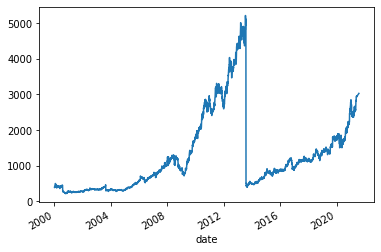

In [11]:
df['closing'].plot()

* Load up minutewise data of Nifty
* Chop it into baskets of days
* For each day, find the maximum and also the hover levels at around 1:00pm
* Hypotheses is that Short Covering happens nearly every day around 1pm, or 2pm - and particularly on days where morning half sees a good upward rally and little downward rally.
* So, if morning has been in strong uptrend, what is the statistical frequency of a 'significant' short-covering
* With entry around 1/1:15pm at spot, how many point movement can be expected?
* What should be the stop-loss?